In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import (mean_squared_error, max_error, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, make_scorer, matthews_corrcoef)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import joblib

In [2]:
df = pd.read_csv("biodegradable_a.csv")
df.shape

(4564, 42)

In [3]:
X = df.drop(columns="Biodegradable")
y = df.Biodegradable

In [4]:
#new biodegradable (new_x):  1 if RB else -1
y = y.map(lambda x: 1 if x=='RB' else -1)

In [5]:
#Criação do train + test e validation set
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.25, random_state=22)

In [6]:
y_Train.value_counts()

 1    2858
-1     565
Name: Biodegradable, dtype: int64

In [7]:
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3423 entries, 4057 to 2933
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SpMax_L   3423 non-null   float64
 1   J_Dz(e)   3423 non-null   float64
 2   nHM       3423 non-null   float64
 3   F01       3034 non-null   float64
 4   F04       3423 non-null   float64
 5   NssssC    3423 non-null   float64
 6   nCb       3423 non-null   float64
 7   C         2850 non-null   float64
 8   nCp       2926 non-null   float64
 9   nO        3423 non-null   float64
 10  F03       3423 non-null   float64
 11  SdssC     3423 non-null   float64
 12  HyWi_B    3076 non-null   float64
 13  LOC       3423 non-null   float64
 14  SM6_L     3423 non-null   float64
 15  F03_CO    3396 non-null   float64
 16  Me        3091 non-null   float64
 17  Mi        3423 non-null   float64
 18  nN_N      3423 non-null   float64
 19  nArNO2    3423 non-null   float64
 20  nCRX3     3423 non-null   f

In [8]:
print(
    f"Maximum missing attributes on the rows: {X_Train.isna().sum(axis=1).max()}"
)

Maximum missing attributes on the rows: 6


In [9]:
missing_cols = X_Train.isna().sum()
missing_cols[missing_cols>0]

F01         389
C           573
nCp         497
HyWi_B      347
F03_CO       27
Me          332
nCIR        373
SpMax_A     494
SdO         166
nCrt        177
SpMax_B    1003
Psi_i_A     317
nX          513
dtype: int64

Number of null values is significant on many columns ( > 25% ) <br>
Droping features is not an option for dealing with missing data, because we do not have the knowledge yet if they have relation with the class we want to predict<br>

However, per sample, 6 out of 40 attributes doesn't seem very significant.
This before the feature selection.

## Classification Models

- ~[ ] Logit~
- ~[ ] LDA~
- [x] SVM
- ~[ ] Naive Bayes~
- ~[ ] DecisionTree~
- [x] KNN
- [x] Bagging:
    - RandomForest
- [ ] Boosting 

# Testing Imputation Models

## Test with MinMaxScaler

In [10]:
X_train_not_nan = X_Train.dropna()

In [11]:
X_train_not_nan.shape

(698, 41)

In [12]:
X_Train.shape

(3423, 41)

The difference in the number of rows, from the variable *X_train_not_nan* and the variable *X_train* indicates that a huge number of instances are missing at least one of the features, hence droping rows is not a viable option

In [13]:
priors = X_Train.isna().sum()/X_Train.shape[0]
priors.shape

(41,)

In [14]:
def get_mask(X,priors):
    masks = np.empty(shape = X.shape, dtype=np.bool_)
    for i, p in enumerate(priors):
        masks[:, i] = np.random.choice((True,False), size=masks.shape[0], p=(p,1-p))
    return masks

In [15]:
scaler = MinMaxScaler().fit(X_train_not_nan)
X_train_not_nan_scaled = pd.DataFrame(data = scaler.transform(X_train_not_nan),
                                      columns=X_train_not_nan.columns)

In [16]:
N = 200
masks = [get_mask(X_train_not_nan, priors) for _ in range(N)]

In [17]:
imputers = (
        SimpleImputer(),
        SimpleImputer(strategy="median"),
        KNNImputer()
)
labels = ["SimpleImpute_mean", "SimpleImpute_median", "KNN"]

results = pd.DataFrame(index=X_train_not_nan.columns)
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_not_nan.columns)
    for _ in range(N):
        X_masked = X_train_not_nan_scaled.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_not_nan_scaled.columns, 
                                 mean_squared_error(X_train_not_nan_scaled, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [18]:
results[results>0].dropna()

,SimpleImpute_mean,SimpleImpute_median,KNN
F01,0.010965,0.010156,0.010918
C,0.071182,0.071806,0.029419
nCp,0.046040,0.046620,0.033474
HyWi_B,0.041540,0.041585,0.016123
F03_CO,0.015739,0.016486,0.007631
Me,0.033439,0.033744,0.017917
nCIR,0.025312,0.029161,0.015978
SpMax_A,0.044344,0.044394,0.018865
SdO,0.041624,0.041836,0.016827
nCrt,0.009086,0.008199,0.007618


In [19]:
results[results>0].dropna().sum()

SimpleImpute_mean      0.448405
SimpleImpute_median    0.453814
KNN                    0.235105
dtype: float64

The *KNNImputer* is the one that better predicts the missing values, according to this test, since it is the one that gets closer results for every feature with missing values, which results having the least summed error. <br>
Not many different parameters were used for it, so it can probably achieve even better results.

In [20]:
imputers = (
        KNNImputer(n_neighbors=i) for i in range(3,11)
)

labels = [f"KNN_{i}_neighbors" for i in range(3,11)]

results = pd.DataFrame(index=X_train_not_nan.columns)
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_not_nan.columns)
    for _ in range(N):
        X_masked = X_train_not_nan_scaled.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_not_nan_scaled.columns, 
                                 mean_squared_error(X_train_not_nan_scaled, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [21]:
results[results>0].dropna()

,KNN_3_neighbors,KNN_4_neighbors,KNN_5_neighbors,KNN_6_neighbors,KNN_7_neighbors,KNN_8_neighbors,KNN_9_neighbors,KNN_10_neighbors
F01,0.011094,0.011080,0.010918,0.010740,0.010537,0.010364,0.010274,0.010267
C,0.027843,0.028718,0.029419,0.030104,0.030831,0.031433,0.032004,0.032430
nCp,0.032791,0.033162,0.033474,0.033942,0.034269,0.034612,0.034874,0.035139
HyWi_B,0.014963,0.015615,0.016123,0.016571,0.016968,0.017323,0.017648,0.017963
F03_CO,0.007777,0.007785,0.007631,0.007612,0.007642,0.007678,0.007779,0.007837
Me,0.016851,0.017215,0.017917,0.018458,0.018991,0.019392,0.019722,0.019898
nCIR,0.015557,0.015692,0.015978,0.016210,0.016370,0.016518,0.016645,0.016792
SpMax_A,0.017633,0.018257,0.018865,0.019355,0.019751,0.020158,0.020521,0.020877
SdO,0.015770,0.016403,0.016827,0.017286,0.017700,0.018014,0.018385,0.018596
nCrt,0.006830,0.007294,0.007618,0.007781,0.007896,0.007878,0.007843,0.007898


In [22]:
results[results>0].dropna().sum()

KNN_3_neighbors     0.221293
KNN_4_neighbors     0.228658
KNN_5_neighbors     0.235105
KNN_6_neighbors     0.240798
KNN_7_neighbors     0.245668
KNN_8_neighbors     0.249774
KNN_9_neighbors     0.253535
KNN_10_neighbors    0.256745
dtype: float64

In [23]:
results[results>0].dropna().sum().idxmin()

'KNN_3_neighbors'

## Test with StandardScaler

In [ ]:
pd.concat( (X_Train, y_Train), axis=1)

In [24]:
#Normalização por Standard Scaler
scaler = StandardScaler()
X_Train_scaled=scaler.fit_transform(X_train_not_nan)
X_train_stdScaler=pd.DataFrame(
    data = X_Train_scaled,
    columns=X_Train.columns
)
X_train_stdScaler

,SpMax_L,J_Dz(e),nHM,F01,F04,NssssC,nCb,C,nCp,nO,...,nCrt,C_026,F02_CN,nHDon,SpMax_B,Psi_i_A,nN,SM6_B,nArCOOR,nX
0,0.230733,1.389010,-0.232094,-0.071715,1.025951,-0.128021,-0.583471,-0.400740,1.488723,-0.034949,...,-0.096025,-0.335282,2.457302,-0.678067,-0.100319,-0.438917,1.213572,0.024492,-0.225584,-0.139311
1,1.261726,0.682137,-0.232094,-0.071715,-0.255111,1.167032,-0.583471,-1.006461,2.322026,-0.034949,...,-0.096025,-0.335282,-0.336178,1.036755,-0.489638,0.353644,-0.399901,-0.902555,-0.225584,-0.139311
2,0.163050,-0.299268,-0.232094,-0.071715,-0.255111,-0.128021,0.169325,0.895370,-0.177883,0.642670,...,-0.096025,-0.335282,-0.336178,0.179344,0.031227,-0.235835,-0.399901,0.100488,-0.225584,-0.139311
3,0.023820,0.060363,-0.232094,-0.071715,-0.255111,-0.128021,0.169325,1.419572,-1.011186,-0.034949,...,-0.096025,-0.335282,-0.336178,-0.678067,0.114656,0.382507,-0.399901,-0.009828,-0.225584,-0.139311
4,-1.193804,-0.517543,-0.232094,-0.071715,-0.255111,-0.128021,-0.583471,-0.421137,0.655420,-1.390186,...,-0.096025,-0.335282,-0.336178,-0.678067,-0.975716,-1.355502,-0.399901,-0.703168,-0.225584,-0.139311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,-0.128030,0.289936,-0.232094,-0.071715,-0.255111,-0.128021,-0.583471,-0.273512,-0.177883,-0.034949,...,-0.096025,-0.335282,-0.336178,-0.678067,-0.312834,-0.692220,-0.399901,0.410503,-0.225584,-0.139311
694,2.407050,-1.678164,-0.232094,-0.071715,-0.255111,2.462085,-0.583471,0.083838,0.655420,-0.034949,...,5.059796,-0.335282,-0.336178,1.036755,0.101377,-0.878552,-0.399901,0.072831,-0.225584,-0.139311
695,1.540535,1.441187,2.241214,-0.071715,-0.255111,1.167032,-0.583471,-1.006461,2.322026,-0.034949,...,-0.096025,-0.335282,-0.336178,1.036755,5.132820,0.136108,-0.399901,4.457771,-0.225584,1.046530
696,0.122419,0.463956,2.241214,-0.071715,-0.255111,-0.128021,-0.583471,1.319510,-1.011186,-1.390186,...,-0.096025,-0.335282,1.526142,-0.678067,0.626723,-0.139235,1.213572,0.756031,-0.225584,1.046530


In [25]:
imputers = (
        SimpleImputer(),
        SimpleImputer(strategy="median"),
        KNNImputer()
)
labels = ["SimpleImpute_mean", "SimpleImpute_median", "KNN"]

results = pd.DataFrame(index=X_train_not_nan.columns)
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_not_nan.columns)
    for _ in range(N):
        X_masked = X_train_stdScaler.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_stdScaler.columns, 
                                 mean_squared_error(X_train_stdScaler, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [26]:
results[results>0].dropna()

,SimpleImpute_mean,SimpleImpute_median,KNN
F01,0.219546,0.203344,0.197309
C,0.408742,0.412327,0.156577
nCp,0.383649,0.388483,0.271883
HyWi_B,0.317709,0.318053,0.118230
F03_CO,0.083638,0.087605,0.042258
Me,0.311145,0.313987,0.174563
nCIR,0.307393,0.354139,0.193520
SpMax_A,0.374618,0.375034,0.156668
SdO,0.217326,0.218430,0.090300
nCrt,0.140541,0.126821,0.110844


In [27]:
results[results>0].dropna().sum()

SimpleImpute_mean      3.927211
SimpleImpute_median    3.967322
KNN                    2.176536
dtype: float64

Similarly to the MinMaxScaler, KNN imputer is the model that has the least error on it's predictions.

In [28]:
imputers = (
        KNNImputer(n_neighbors=i) for i in range(3,11)
)

labels = [f"KNN_{i}_neighbors" for i in range(3,11)]

results = pd.DataFrame(index=X_train_not_nan.columns)
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_not_nan.columns)
    for _ in range(N):
        X_masked = X_train_stdScaler.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_stdScaler.columns, 
                                 mean_squared_error(X_train_stdScaler, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [29]:
results[results>0].dropna()

,KNN_3_neighbors,KNN_4_neighbors,KNN_5_neighbors,KNN_6_neighbors,KNN_7_neighbors,KNN_8_neighbors,KNN_9_neighbors,KNN_10_neighbors
F01,0.188531,0.193508,0.197309,0.198331,0.200640,0.202087,0.202417,0.202298
C,0.149070,0.152211,0.156577,0.160919,0.164755,0.167421,0.170383,0.172426
nCp,0.264998,0.268437,0.271883,0.275113,0.278150,0.281683,0.283828,0.286294
HyWi_B,0.111617,0.114726,0.118230,0.121211,0.124150,0.126623,0.129073,0.131566
F03_CO,0.042328,0.042402,0.042258,0.042607,0.042182,0.042216,0.042367,0.042737
Me,0.159654,0.167183,0.174563,0.180140,0.184816,0.188366,0.189951,0.191669
nCIR,0.188563,0.190858,0.193520,0.195712,0.198363,0.200506,0.202640,0.204249
SpMax_A,0.149849,0.153769,0.156668,0.160889,0.164458,0.167400,0.169993,0.172447
SdO,0.083552,0.086530,0.090300,0.092575,0.093994,0.095157,0.096537,0.097995
nCrt,0.099736,0.106098,0.110844,0.114358,0.116704,0.118690,0.119831,0.120522


In [30]:
results[results>0].dropna().sum()

KNN_3_neighbors     2.031211
KNN_4_neighbors     2.108377
KNN_5_neighbors     2.176536
KNN_6_neighbors     2.235428
KNN_7_neighbors     2.286577
KNN_8_neighbors     2.329643
KNN_9_neighbors     2.363098
KNN_10_neighbors    2.393115
dtype: float64

In [31]:
results[results>0].dropna().sum().idxmin()

'KNN_3_neighbors'

## Test with Power Transformer

In [32]:
#FAZER FUNÇAO PARA NAO REPETIR O CODIGO DEPOIS

#Normalização por Power Transform

X_Train_powerTscaled=PowerTransformer().fit_transform(X_train_not_nan)
X_train_powerTscaler=pd.DataFrame(
    data = X_Train_powerTscaled,
    columns=X_Train.columns
)
#X_train_powerTscaler

In [33]:
imputers = (
        SimpleImputer(),
        SimpleImputer(strategy="median"),
        KNNImputer()
)
labels = ["SimpleImpute_mean", "SimpleImpute_median", "KNN"]

results = pd.DataFrame(index=X_train_not_nan.columns)
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_not_nan.columns)
    for _ in range(N):
        X_masked = X_train_powerTscaler.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_powerTscaler.columns, 
                                 mean_squared_error(X_train_powerTscaler, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [34]:
results[results>0].dropna().sum()

SimpleImpute_mean      4.035830
SimpleImpute_median    4.151941
KNN                    1.911194
dtype: float64

As we can see, KNN has the minimum error in every scalling method, so we will only use KNN-Imputer.

In [35]:
imputers = (
        KNNImputer(n_neighbors=i) for i in range(3,11)
)

labels = [f"KNN_{i}_neighbors" for i in range(3,11)]

results = pd.DataFrame(index=X_train_not_nan.columns)
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_not_nan.columns)
    for _ in range(N):
        X_masked = X_train_powerTscaler.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_powerTscaler.columns, 
                                 mean_squared_error(X_train_powerTscaler, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [36]:
results[results>0].dropna().sum()

KNN_3_neighbors     1.786428
KNN_4_neighbors     1.855037
KNN_5_neighbors     1.911194
KNN_6_neighbors     1.965469
KNN_7_neighbors     2.012155
KNN_8_neighbors     2.054684
KNN_9_neighbors     2.090218
KNN_10_neighbors    2.118666
dtype: float64

In [37]:
results[results>0].dropna().sum().idxmin()

'KNN_3_neighbors'

## Imputer Results

For all the cases tested, the 3-NN imputer was the one that obtained better results

# Scale and impute the rest of the data

Perform imputation of missing values before scaling, as scaling could lead to distorted data if the missing values are not first replaced. This is because some calculations may include the missing values and their presence could lead to skewed results.

## Impute data with knn

In [ ]:
# Create an instance of the KNNImputer
imputer = KNNImputer()

X_Train_imputed = imputer.fit_transform(X_Train)

X_Train_imputed

## Scale with PowerTransform

In [ ]:
pt = PowerTransformer()
X_Train_imputed_powerT = pt.fit_transform(X_Train_imputed)

# Feature Selection using RandomForest

Fitting a tree find the best features.

In [10]:
def get_sorted_labels(col_names : list[str], pipeline: Pipeline) -> list[str]:
    #join names and scores in tuples (column, score)
    label_scores = zip(col_names, pipeline["selector"].estimator_.feature_importances_)
    
    #sort tuples accoding to value in index 1 (column, -> score <-)
    sorted_labels = sorted(label_scores, key = lambda x: x[1], reverse=True)
    
    return sorted_labels

In [11]:
def conf_mat(y_test, pred):
    ConfusionMatrixDisplay(
        confusion_matrix(y_test, pred)
    ).plot()

In [12]:
def scatter_3d(x, y, z, score, xlabel="", ylabel="", zlabel="", ):
    f, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection":"3d"})
    im = ax.scatter(x, 
                    y, 
                    z, 
                   c = score,
                    #s=50
              )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('MCC Score', rotation=0)
    f.tight_layout()

In [13]:
def scatter_2d(x, y, score, xlabel="", ylabel="", ax = None, cb=False):
    if ax==None:
        f, ax = plt.subplots()
    im = ax.scatter(x,y, c=score)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if cb:
        cbar = plt.colorbar(im)
        cbar.ax.set_ylabel("MCC Scores", rotation=0)
    

In [14]:
filter_ = lambda key,value, arr: list(filter(lambda x: x[key]==value, arr))

In [15]:
map_ = lambda key, arr: list(map(lambda x: x[key], arr))

In [71]:
best_score = lambda grid_search : max(grid_search.cv_results_["mean_test_score"])

In [17]:
(X_Train.std()==0).any()

False

In [30]:
def index_from(label, arr):
    for i in range(len(arr)):
        if arr[i]["classifier__criterion"] == label:
            yield i

There are no features with constant values, so there is no need to drop any column

In [18]:
np.abs(pd.concat((X_Train, y_Train), axis=1).corr()["Biodegradable"]).sort_values(ascending=False)[:5]

Biodegradable    1.000000
nHM              0.466193
C_026            0.422011
F02_CN           0.417339
B03              0.399126
Name: Biodegradable, dtype: float64

## Models with **MinMaxScaler**

### Random Forest Classifier

In [98]:
FILENAME = "MinMax-RF_v3"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    pipeline = [
                ("scaler", MinMaxScaler()),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", RandomForestClassifier(
                        min_samples_leaf= 1,
                    
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
        'selector__max_features': range(22, 38),
         'classifier__criterion': ['gini', 'entropy'],
         'classifier__max_depth': range(25, 36)
         #'classifier__min_samples_leaf': [1, 2]
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

In [37]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 20,
 'classifier__min_samples_split': 3,
 'selector__max_features': 40}

In [38]:
search_results.cv_results_["mean_test_score"]

210

In [65]:
method="gini"
is_2nd_half = 1 if method=="gini" else 0 
size = int(len(search_results.cv_results_["mean_test_score"]) / 2)

data = list(filter(lambda x: x["classifier__criterion"]==method, search_results.cv_results_["params"]))

x_max_depth = list(map(lambda x: x["classifier__max_depth"], data))
#y_min_samples_leaf = list(map(lambda x: x["classifier__min_samples_leaf"], data))
z_max_features = list(map(lambda x: x["selector__max_features"], data))

scores = search_results.cv_results_["mean_test_score"][ is_2nd_half*size : (is_2nd_half+1)*size ]

In [52]:
get_sorted_labels(X_Train.columns, search_results.best_estimator_);

In [53]:
list(filter(lambda item: item[1]>0.02, get_sorted_labels(X_Train.columns, search_results.best_estimator_)));

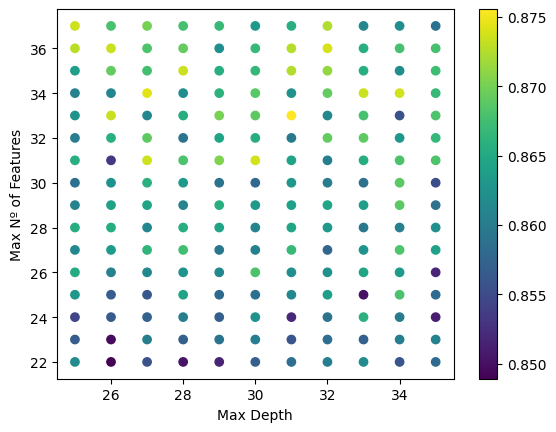

In [69]:
%matplotlib inline
im = plt.scatter(x_max_depth, z_max_features, c=scores)
plt.colorbar(im)
plt.xlabel("Max Depth")
plt.ylabel("Max Nº of Features")
plt.show()

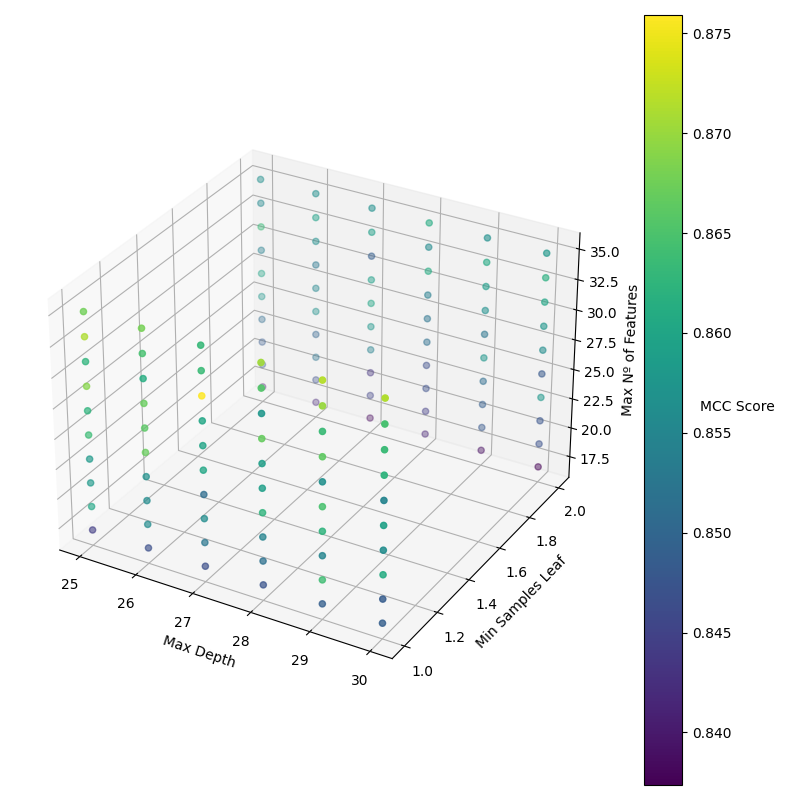

In [57]:
%matplotlib widget
#plt.figure(figsize=(12,12))

f, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection":"3d"})
im = ax.scatter(x_max_depth, 
           y_min_samples_leaf, 
           z_max_features, 
           c = scores,
           cmap=plt.viridis(),
            #s=50
          )
ax.set_xlabel("Max Depth")
ax.set_ylabel("Min Samples Leaf")
ax.set_zlabel("Max Nº of Features")

cbar = plt.colorbar(im)
cbar.ax.set_ylabel('MCC Score', rotation=0)
plt.tight_layout()

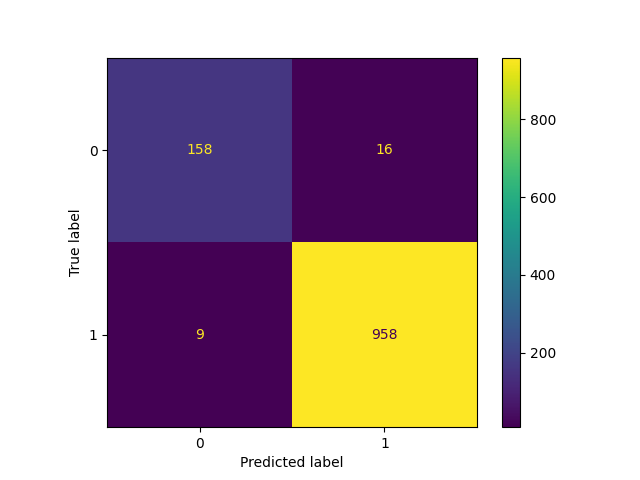

In [99]:
conf_mat(y_Test, search_results.predict(X_Test))

In [72]:
print("1st Search=", best_score(joblib.load("MinMax-RF")) )
print("2nd Search=", best_score(joblib.load("MinMax-RF_v2")) )
print("3rd Search=", best_score(joblib.load("MinMax-RF_v3")) )

1st Search= 0.8717027139452618
2nd Search= 0.8826842301075987
3rd Search= 0.8875354307629199


In [85]:
joblib.load("MinMax-RF_v2").param_grid

{'selector__max_features': range(17, 36, 2),
 'classifier__criterion': ['gini', 'entropy'],
 'classifier__max_depth': range(25, 31),
 'classifier__min_samples_leaf': [1, 2]}

### Decision Tree Classifier

In [51]:
FILENAME = "MinMax-DT_v3"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    pipeline = [
                ("scaler", MinMaxScaler()),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", DecisionTreeClassifier(
                        min_samples_leaf= 1,
                    min_samples_split=3
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
        'selector__max_features': range(34, 40+1, 1),
         'classifier__criterion': ['gini', 'entropy'],
         'classifier__max_depth': range(15, 23+1, 1),
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True,
                                  pre_dispatch=2,
                                  error_score=0
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

Fitting 9 folds for each of 126 candidates, totalling 1134 fits


In [52]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 17,
 'selector__max_features': 40}

In [53]:
best_score(search_results)

MCC =  0.8298842556479843


In [55]:
data = filter_("classifier__criterion", "gini", search_results.cv_results_["params"])

x_depth = map_("classifier__max_depth", data)
#y_split = map_("classifier__min_samples_split", data)
z_feat = map_("selector__max_features", data)

idx = list(index_from("gini", search_results.cv_results_["params"]))
score = search_results.cv_results_["mean_test_score"][idx]

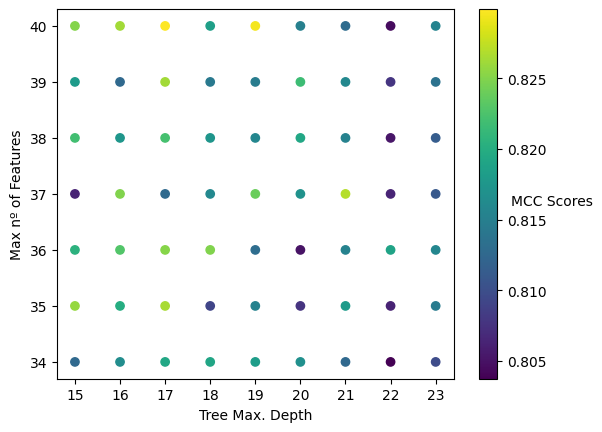

In [57]:
%matplotlib inline

scatter_2d(x_depth,
           #y_split,
           z_feat,
           score,
           xlabel="Tree Max. Depth",
           #ylabel="Min. Samples Split",
           ylabel="Max nº of Features",
           cb=True
)

In [73]:
print("1st Search=", best_score(joblib.load("MinMax-DT")) )
print("2nd Search=", best_score(joblib.load("MinMax-DT_v2")) )
print("3rd Search=", best_score(joblib.load("MinMax-DT_v3")) )

1st Search= 0.8267998980811414
2nd Search= 0.8230894729577813
3rd Search= 0.8255544544077312


## Models with **Standard Scaler**

### Random Forest Classifier

In [94]:
FILENAME = "StdScaler-RF_v3"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    pipeline = [
                ("scaler", StandardScaler()),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", RandomForestClassifier(
                        min_samples_leaf= 1, 
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
        'selector__max_features': range(20, 33, 1),
         'classifier__criterion': ['gini', 'entropy'],
         'classifier__max_depth': range(25, 36, 1),
         #'classifier__class_weight' : ["balanced", None, "balanced_subsample"]
         #'classifier__min_samples_leaf': range(1, 15, 2)
        
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

In [56]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 25,
 'selector__max_features': 31}

In [57]:
method="gini"
is_2nd_half = 1 if method=="gini" else 0 
size = int(len(search_results.cv_results_["mean_test_score"]) / 2)
data = list(filter(lambda x: x["classifier__criterion"]==method, search_results.cv_results_["params"]))
#x_max_depth = list(map(lambda x: x["classifier__max_depth"], data))
#z_max_features = list(map(lambda x: x["selector__max_features"], data))

scores = search_results.cv_results_["mean_test_score"][ is_2nd_half*size : (is_2nd_half+1)*size ]

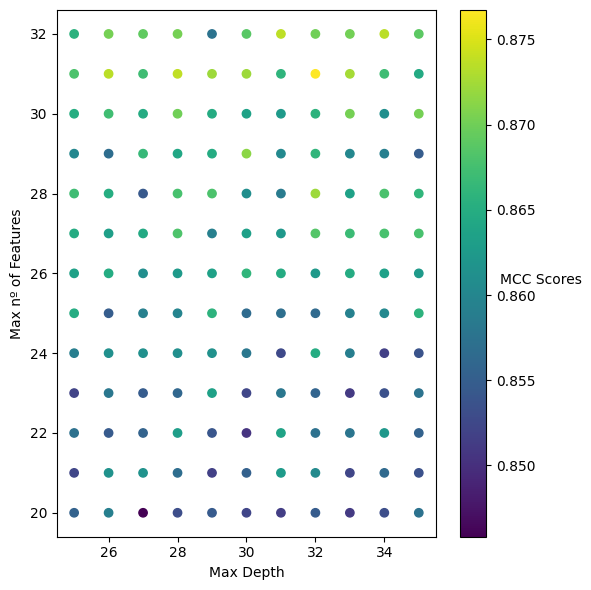

In [64]:
%matplotlib inline
#plt.figure(figsize=(12,12))
f, ax = plt.subplots(1,1, figsize=(6, 6))

scatter_2d(map_("classifier__max_depth", data),
           map_("selector__max_features", data),
           scores,
           xlabel="Max Depth",
           ylabel="Max nº of Features",
           ax = ax,
          cb=True)
f.tight_layout()

In [74]:
print("1st Search=", best_score(joblib.load("StdScaler-RF")) )
print("2nd Search=", best_score(joblib.load("StdScaler-RF_v2")) )
print("3rd Search=", best_score(joblib.load("StdScaler-RF_v3")) )

1st Search= 0.8708650009437577
2nd Search= 0.8797372667711048
3rd Search= 0.88481634647757


### Decision Tree Classifier

In [59]:
joblib.load("MinMax-DT").param_grid

{'selector__max_features': range(10, 41, 10),
 'classifier__criterion': ['gini', 'entropy'],
 'classifier__max_depth': range(10, 61, 10),
 'classifier__min_samples_split': range(2, 10)}

In [86]:
joblib.load("MinMax-DT_v2").param_grid

{'selector__max_features': range(20, 41, 5),
 'classifier__criterion': ['gini', 'entropy'],
 'classifier__max_depth': range(10, 41, 5),
 'classifier__min_samples_split': range(2, 5)}

In [87]:
joblib.load("MinMax-DT_v3").param_grid

{'selector__max_features': range(30, 41, 2),
 'classifier__criterion': ['gini', 'entropy'],
 'classifier__max_depth': range(15, 36, 3),
 'classifier__min_samples_split': range(2, 4)}

In [89]:
FILENAME = "StdScaler-DT"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    pipeline = [
                ("scaler", StandardScaler()),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", DecisionTreeClassifier(
                        min_samples_leaf= 1,
                    min_samples_split=3
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
         'selector__max_features': range(20, 41, 10),
         'classifier__criterion': ['gini', 'entropy'],
         'classifier__max_depth': range(10, 61, 10),
         'classifier__min_samples_split': range(2, 10)
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True,
                                  pre_dispatch=2,
                                  error_score=0
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

Fitting 9 folds for each of 288 candidates, totalling 2592 fits


In [90]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 60,
 'classifier__min_samples_split': 6,
 'selector__max_features': 40}

In [91]:
best_score(search_results)

0.8220050039446496

In [92]:
data = filter_("classifier__criterion", "gini", search_results.cv_results_["params"])

x_depth = map_("classifier__max_depth", data)
y_split = map_("classifier__min_samples_split", data)
z_feat = map_("selector__max_features", data)

idx = list(index_from("gini", search_results.cv_results_["params"]))
score = search_results.cv_results_["mean_test_score"][idx]

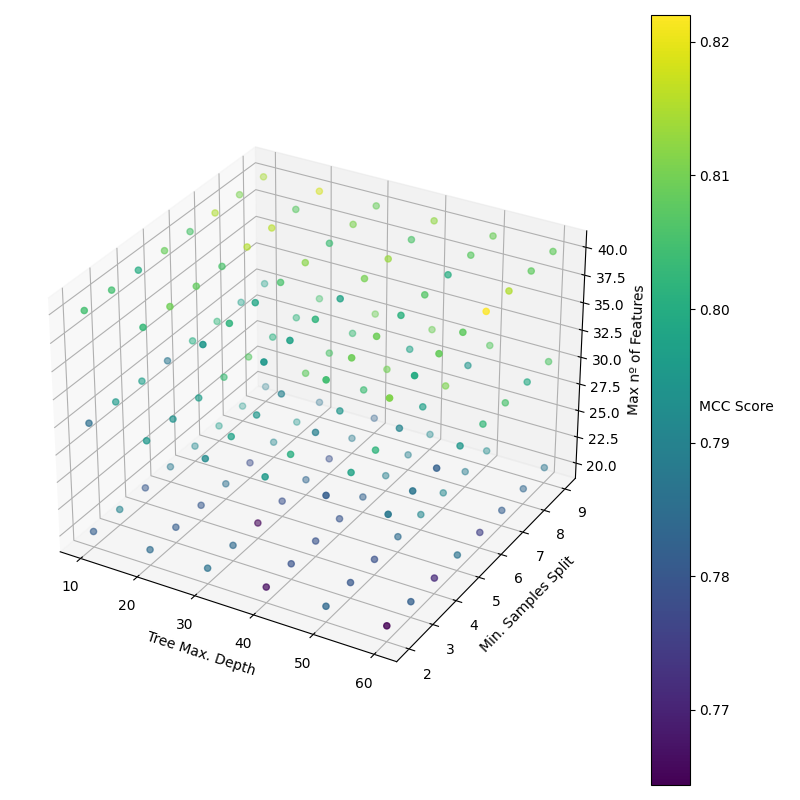

In [93]:
%matplotlib widget

scatter_3d(x_depth,
           y_split,
           z_feat,
           score,
           xlabel="Tree Max. Depth",
           ylabel="Min. Samples Split",
           zlabel="Max nº of Features",
           #cb=True
)

## Using **Power Tranformer**

### Another way to do the same. choose later

### RandomForest Classifier

In [71]:
FILENAME = "PowerTransformer-RF_v2"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    pipeline = [
                ("scaler", PowerTransformer()),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", RandomForestClassifier(
                        min_samples_leaf= 1, 
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
        'selector__max_features': range(22, 39, 2),
         'classifier__criterion': ['gini', 'entropy'],
         'classifier__max_depth': range(18, 35, 1),
         #'classifier__class_weight' : ["balanced", None, "balanced_subsample"]
         'classifier__min_samples_leaf': [1, 2]
        
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

Fitting 9 folds for each of 612 candidates, totalling 5508 fits


In [72]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 33,
 'classifier__min_samples_leaf': 1,
 'selector__max_features': 34}

In [73]:
method="gini"
is_2nd_half = 1 if method=="gini" else 0 
size = int(len(search_results.cv_results_["mean_test_score"]) / 2)
data = list(filter(lambda x: x["classifier__criterion"]==method, search_results.cv_results_["params"]))
#x_max_depth = list(map(lambda x: x["classifier__max_depth"], data))
#z_max_features = list(map(lambda x: x["selector__max_features"], data))

scores = search_results.cv_results_["mean_test_score"][ is_2nd_half*size : (is_2nd_half+1)*size ]

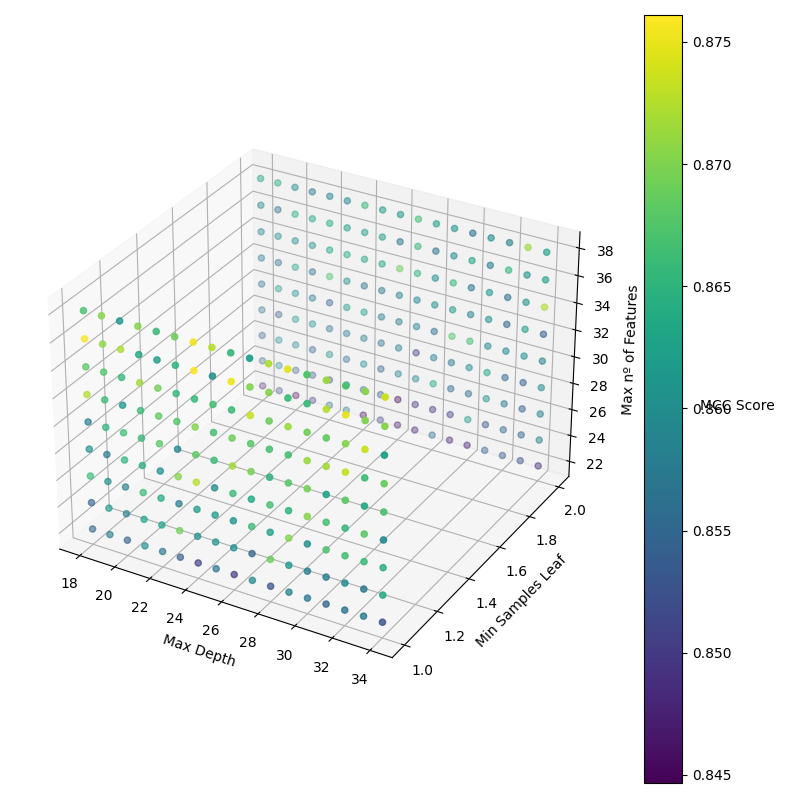

In [74]:
%matplotlib widget

scatter_3d(
    map_("classifier__max_depth", data),
    map_("classifier__min_samples_leaf", data),
    map_("selector__max_features", data),
    scores,
    xlabel="Max Depth",
    ylabel="Min Samples Leaf",
    zlabel="Max nº of Features",
)

In [77]:
print("1st Search=", best_score(joblib.load("PowerTransformer-RF")) )
print("2nd Search=", best_score(joblib.load("PowerTransformer-RF_v2")) )

1st Search= 0.876738237891391
2nd Search= 0.8842192334536212


### Decision Tree Classifier

In [94]:
FILENAME = "PowerTransformer-DT"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    pipeline = [
                ("scaler", PowerTransformer()),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", DecisionTreeClassifier(
                        min_samples_leaf= 1,
                    min_samples_split=3
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
         'selector__max_features': range(20, 41, 10),
         'classifier__criterion': ['gini', 'entropy'],
         'classifier__max_depth': range(10, 61, 10),
         'classifier__min_samples_split': range(2, 10)
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True,
                                  pre_dispatch=2,
                                  error_score=0
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

Fitting 9 folds for each of 288 candidates, totalling 2592 fits


In [95]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 20,
 'classifier__min_samples_split': 2,
 'selector__max_features': 40}

In [96]:
best_score(search_results)

0.8224788986277655